In [15]:
from z3 import *
import numpy as np
from itertools import product
from skimage.morphology import label
from scipy.ndimage import measurements
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import time
import warnings
warnings.filterwarnings("ignore", message="Please use `label` from the `scipy.ndimage` namespace")
warnings.filterwarnings("ignore", message="Please use `sum` from the `scipy.ndimage` namespace")

In [16]:
regions = np.array([[0 ,0 ,0 ,0 ,1 ,2 ,2 ,3 ,3 ],
                    [0 ,0 ,6 ,0 ,1 ,2 ,3 ,3 ,4 ],
                    [5 ,0 ,6 ,0 ,0 ,4 ,4 ,4 ,4 ],
                    [5 ,5 ,6 ,6 ,0 ,4 ,8 ,9 ,9 ],
                    [7 ,7 ,6 ,16,0 ,4 ,8 ,9 ,10],
                    [18,7 ,16,16,15,8 ,8 ,10,10],
                    [18,18,16,15,15,15,8 ,11,11],
                    [17,17,16,15,14,13,13,12,12],
                    [17,17,16,15,14,13,13,12,12]], dtype=int)

def sol_print(numbers: np.ndarray, hooks: np.ndarray) -> None:
    _,ax = plt.subplots(1,1,figsize=(8,8))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] = "-"
    ax = sns.heatmap(hooks,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,annot_kws={"fontsize":12})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

def areas(grid: np.ndarray) -> int:
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
    return int(np.prod(areas))

In [17]:
def make_hooks(n: int) -> np.ndarray:
    matrix = np.ones((n, n), dtype=int) * (2*n -1)
    matrix[1:,1:] = 0
    return [np.rot90(matrix, i) for i in range(4)]

hook_17, hook_15, hook_13, hook_11, hook_9, hook_7, hook_5, hook_3 = \
    make_hooks(9), make_hooks(8), make_hooks(7), make_hooks(6), make_hooks(5), make_hooks(4), make_hooks(3), make_hooks(2)
    
orthagonal = lambda i, j, N: [(i+di, j+dj) for (di,dj) in [(0,1),(1,0),(0,-1),(-1,0)] if 0<=i+di<N and 0<=j+dj<N]

def hook_constraint(hook_number: int, board: np.ndarray, N: int) -> PbEq:
    hook = dict[int, list]({17: hook_17, 15: hook_15, 13: hook_13, 11: hook_11, 9: hook_9, 7: hook_7, 5: hook_5, 3: hook_3}).get(hook_number)
    shift = N+1 - (hook_number + 1) // 2
    conditions = list[And]()
    for shift_i, shift_j, h in product(range(shift), range(shift), hook):
        conditions.append(And([board[i+shift_i][j+shift_j]==e for (i,j),e in np.ndenumerate(h) if e]))
    return PbEq([(cond, 1) for cond in conditions], 1)

## Solved in 0.650 seconds

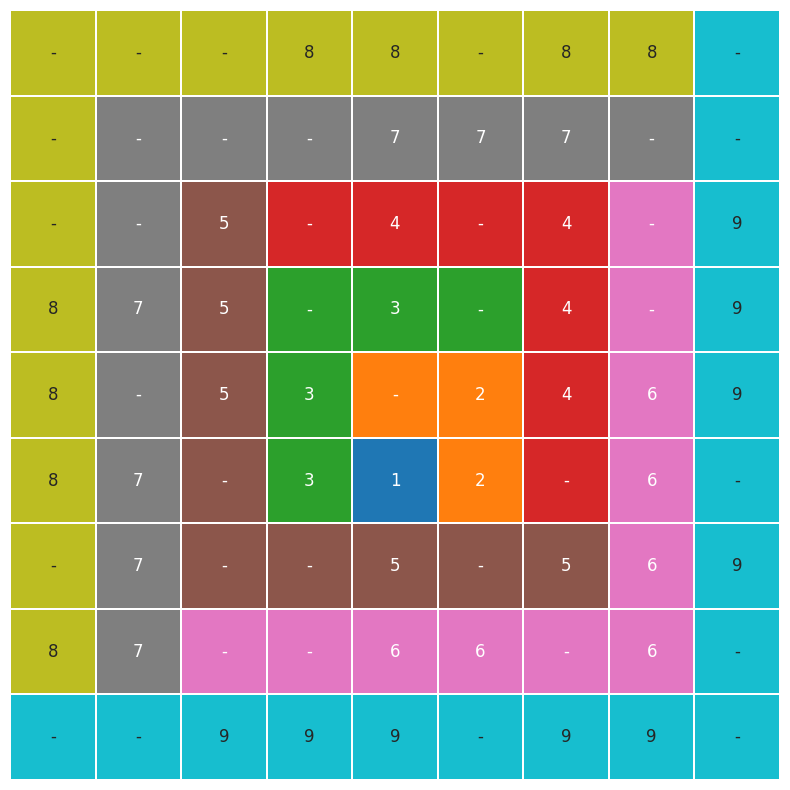

## Answer is: 2,200

In [28]:
start = time.time()
N = len(regions)
s = Solver()
Y = np.array(IntVector("y", N**2), dtype=object).reshape((N,N))
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N))

s += [np.sum(X[regions==i])==15 for i in range(np.max(regions)+1)]
s += [Or(X[i][j]==0,X[i+1][j]==0,X[i][j+1]==0,X[i+1][j+1]==0) for i,j in product(range(N-1), repeat=2)]

s += [And(val >= 0, val <= 9) for val in X.ravel()]
s += [And(val >= 1, val <= 17) for val in Y.ravel()]
s += Or([val==1 for val in Y.ravel()])
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)]
s += [Implies(X[i][j]!=0, Or([X[ni][nj]!=0 for (ni,nj) in orthagonal(i, j, N)])) for (i,j),_ in np.ndenumerate(X)]

for hook_number in [17, 15, 13, 11, 9, 7, 5, 3]:
    s += hook_constraint(hook_number=hook_number, board=Y, N=N)

s += [Implies(Y[i][j]==1, X[i][j]==1) for (i,j),_ in np.ndenumerate(regions)]
s += [Implies(Y[i][j]>3, X[i][j]!=2) for (i,j),_ in np.ndenumerate(regions)]
s += [X[i][j]<=Y[i][j] for (i,j),_ in np.ndenumerate(regions)]

y_to_x_mapping = dict[int, list]({17: 9, 15: 8, 13: 7, 11: 6, 9: 5, 7: 4, 5: 3, 3: 2})
for y_value, x_variable in y_to_x_mapping.items():
    s += [Implies(Y[i][j]==y_value, Or(X[i][j]==x_variable, X[i][j] == 0)) for (i,j),_ in np.ndenumerate(Y)]

while True:
    if s.check():
        m = s.model()
        evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
        result_x = evalu(X)
        if np.max(label(result_x!= 0, connectivity=1)) == 1:
            display(Markdown('## Solved in {:.3f} seconds'.format(time.time()-start)))
            sol_print(numbers=result_x, hooks=evalu(Y))
            display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))
            break
        else:
            s += Or([X[i][j]!=int(result_x[i][j]) for i,j in product(range(N), repeat=2)])